In [1]:
import os
import sys

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.io.wavfile as wav

import importlib
import librosa
import soundfile as sf

import torchnet.meter as tnt
from collections import OrderedDict

from IPython.display import clear_output

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))
sys.path.append(os.path.join(os.getcwd(), '../datasets/'))

import ai8x

from types import SimpleNamespace

In [2]:
trained_checkpoint_path = os.path.join("..", "logs", "benchmark_v2/librispeech_yok/2024.04.23-162623", "qat_best.pth.tar")
mod_qat = importlib.import_module("ai85net-kws20-nas")
dataset = importlib.import_module("kws20")

In [3]:
classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', 'silence', 'unknown']

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
# qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [5]:
model = mod_qat.AI85KWS20NetNAS(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)


checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)

model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

In [6]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

# args = ('/data_ssd', Namespace(act_mode_8bit=False, activation_stats=[], avg_pool_rounding=False, batch_size=256, cnn='ai85kws20netv3', collate_fn=None, compress='policies/schedule_kws20.yaml', cpu=False, csv_prefix=None, data='/data_ssd', dataset='KWS_20', datasets_fn=<function KWS_20_get_datasets at 0x7f917f0f2040>, deterministic=True, device='cuda', dimensions=(128, 128, 1), display_confusion=True, display_embedding=False, display_prcurves=False, earlyexit_lossweights=None, earlyexit_thresholds=None, effective_test_size=1.0, effective_train_size=1.0, effective_valid_size=1.0, epochs=200, evaluate=False, extras=None, generate_sample=None, gpus=None, kd_distill_wt=0.5, kd_pretrained=False, kd_resume='', kd_start_epoch=0, kd_student_wt=0.5, kd_teacher=None, kd_teacher_wt=0.0, kd_temp=1.0, kernel_stats=False, labels=('up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'UNKNOWN'), load_model_path='', load_serialized=False, log_params_histograms=False, lr=0.001, masks_sparsity=False, momentum=0.9, name=None, nas=False, nas_kd_resume_from='', nas_policy='', nas_stage_transition_list=None, no_tensorboard=True, num_best_scores=1, num_classes=21, obj_detection=False, obj_detection_params=None, optimizer='Adam', out_fold_ratio=1, output_dir='logs', pretrained=False, print_freq=10, qat_policy='policies/qat_policy.yaml', qe_bits_accum=32, qe_bits_acts=8, qe_bits_wts=8, qe_calibration=None, qe_clip_acts=<ClipMode.NONE: 0>, qe_clip_n_stds=None, qe_config_file=None, qe_convert_pytorch=False, qe_dynamic=False, qe_mode=<LinearQuantMode.SYMMETRIC: 1>, qe_mode_acts=None, qe_mode_wts=None, qe_no_clip_layers=[], qe_no_quant_layers=[], qe_per_channel=False, qe_pytorch_backend='fbgemm', qe_save_fp_weights=False, qe_scale_approx_bits=None, qe_stats_file=None, quantize_eval=False, regression=False, reset_optimizer=False, resumed_checkpoint_path='', seed=None, sensitivity=None, sensitivity_range=[0.0, 0.95, 0.05], shap=0, show_train_accuracy='last_batch', sparsity_perf=False, summary=None, summary_filename='model', tblog=False, thinnify=False, truncate_testset=False, use_bias=False, validation_split=0.1, visualize_fn=<function visualize_data at 0x7f8fface3790>, weight_decay=0.0, workers=4))

val_dataset, test_dataset = dataset.KWS_12_benchmark_get_datasets( ('/data_ssd', sn), load_train=True, load_test=True)

idx_to_select = (val_dataset.data_type == 2)[:, -1]

val_dataset.data = val_dataset.data[idx_to_select, :] 
val_dataset.targets = val_dataset.targets[idx_to_select, :] 
val_dataset.data_type = val_dataset.data_type[idx_to_select, :] 
val_dataset.shift_limits = val_dataset.shift_limits[idx_to_select, :]

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)


Processing train...
train set: 331395 elements
validation set: 32943 elements
Class down (# 5): 10533 elements
Class go (# 11): 10434 elements
Class left (# 15): 10167 elements
Class no (# 19): 10608 elements
Class off (# 20): 10029 elements
Class on (# 21): 10347 elements
Class right (# 23): 10146 elements
Class stop (# 28): 10383 elements
Class up (# 32): 9894 elements
Class yes (# 35): 10875 elements
Class silence (# 26): 18000 elements
Class UNKNOWN: 242922 elements

Processing test...
test set: 4891 elements
Class down (# 5): 406 elements
Class go (# 11): 402 elements
Class left (# 15): 412 elements
Class no (# 19): 405 elements
Class off (# 20): 402 elements
Class on (# 21): 396 elements
Class right (# 23): 396 elements
Class stop (# 28): 411 elements
Class up (# 32): 425 elements
Class yes (# 35): 419 elements
Class silence (# 26): 408 elements
Class UNKNOWN: 409 elements


In [7]:
for idx, i in enumerate(classes):
    num = sum((val_dataset.targets == idx)[:, -1])
    print(f'Class {i}: {num}')

Class down: 1131
Class go: 1116
Class left: 1056
Class no: 1218
Class off: 1119
Class on: 1089
Class right: 1089
Class stop: 1050
Class up: 1050
Class yes: 1191
Class silence: 3000
Class unknown: 18834


In [163]:
# run an inference loop in batches using val_loader
model.eval()
model.to(device)
classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
confusion = tnt.ConfusionMeter(len(classes))
outputs_all = np.zeros((len(val_dataset), len(classes)))
targets_all = np.zeros((len(val_dataset)))
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        classerr.add(outputs, targets)
        confusion.add(outputs, targets)
        #print("Batch: [",batch_idx*256 ,"/", len(val_dataset),"]")
        acc = classerr.value()[0]
        #print("Accuracy: ", acc)
        outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
        targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
    print("Total Accuracy: ", acc)

Total Accuracy:  92.05293992653978


In [164]:
np.disp(confusion.value())

[[ 1049    24     0    21     0     3     1     7     0     0     2    24]
 [   51   964     1    47     0     1     3     5     3     4     2    35]
 [    1     1   992    18     1     0     4     2     3    13     0    21]
 [   10    17    10  1131     0     0     1     2     1     0     0    46]
 [    1     5     1     0   924    27     1    16   115     2     0    27]
 [    7     2     0     4    32   996     1     0    17     4     0    26]
 [    1     1     9     4     0     2  1005     1     1     0     1    64]
 [    4     9     0     1     5     0     2   985    24     3     1    16]
 [    0     5     6     1    57     6     1    30   904     0     2    38]
 [    3     6    27     7     1     0     2     0     1  1124     0    20]
 [    0     0     0     0     0     0     0     0     0    10  2953    37]
 [  183   294   128   257    90   160   133   155    76    39    21 17298]]


## comparison plots

(0.0, 250.0)

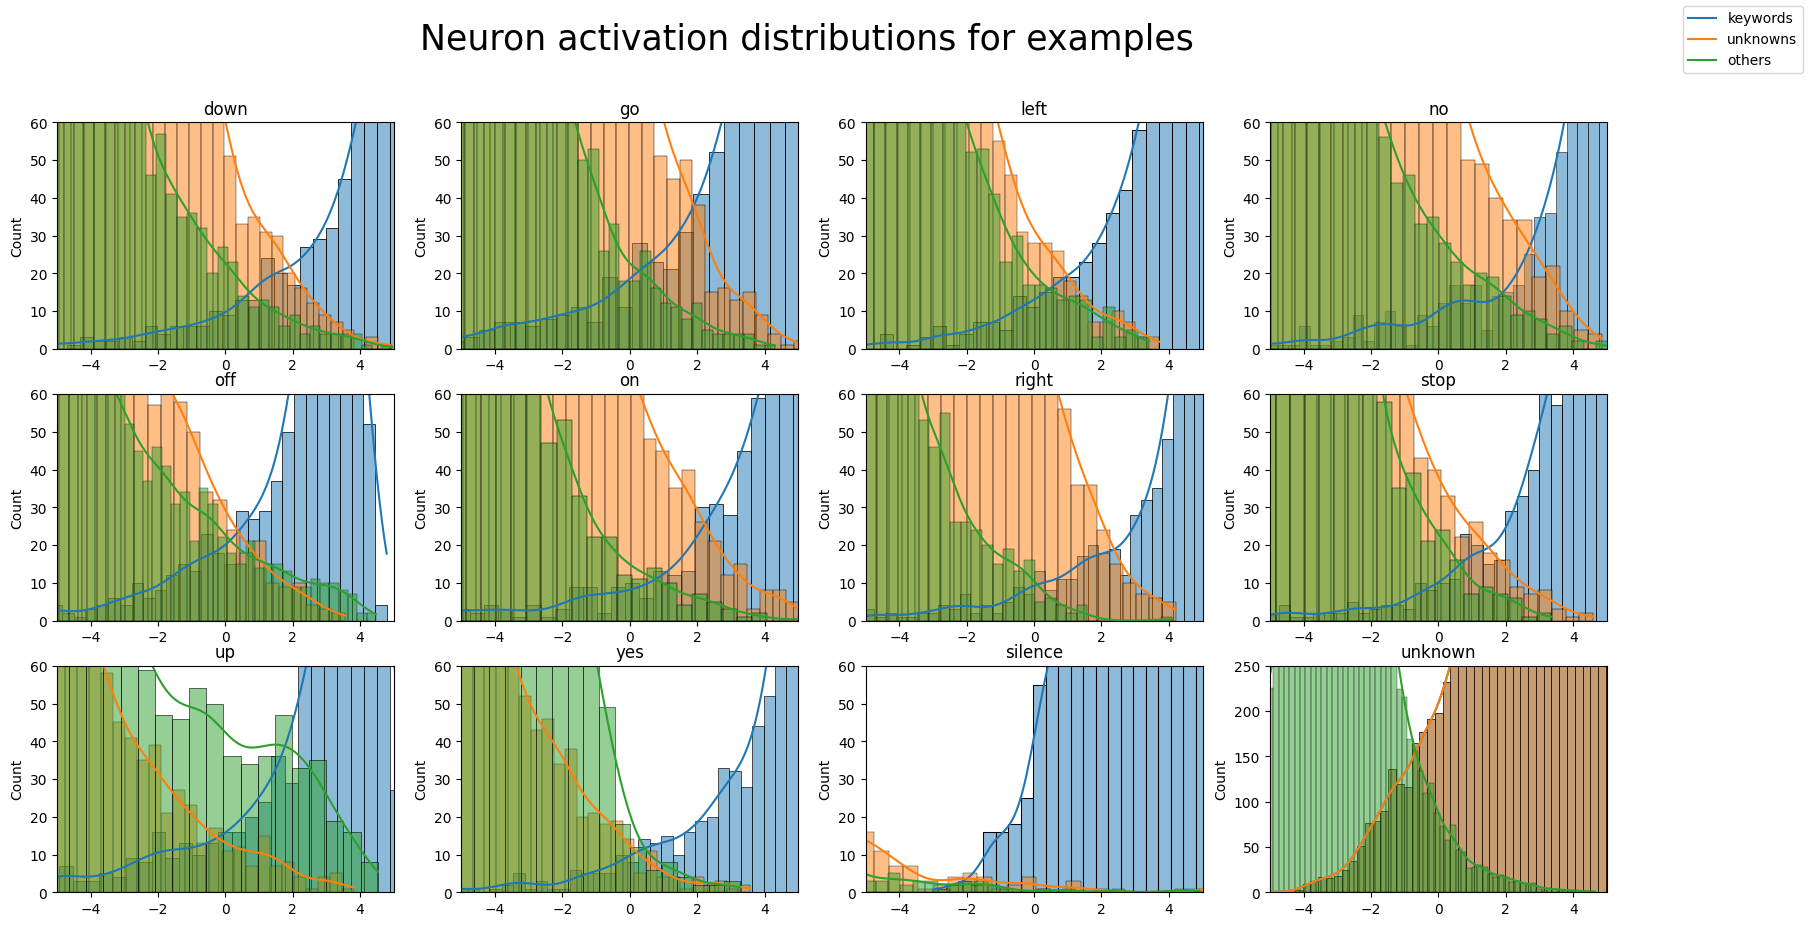

In [44]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle("Neuron activation distributions for examples", fontsize=25)
for i in range(3):
    for j in range(4):
        sns.histplot(outputs_all[(targets_all==i*4+j), i*4+j], kde=True, ax = axs[i,j]) #activation for each keyword
        sns.histplot(outputs_all[(targets_all==11), i*4+j], kde=True, ax = axs[i,j]) #activation for unknowns 
        sns.histplot(outputs_all[(targets_all!=i*4+j) & (targets_all!=11), i*4+j], kde=True, ax = axs[i,j]) #activation for other keywords
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-5, 5)
        axs[i, j].set_ylim(0, 60)
fig.legend(['keywords', 'unknowns', 'others'])
axs[i, j].set_ylim(0, 250)

(0.0, 500.0)

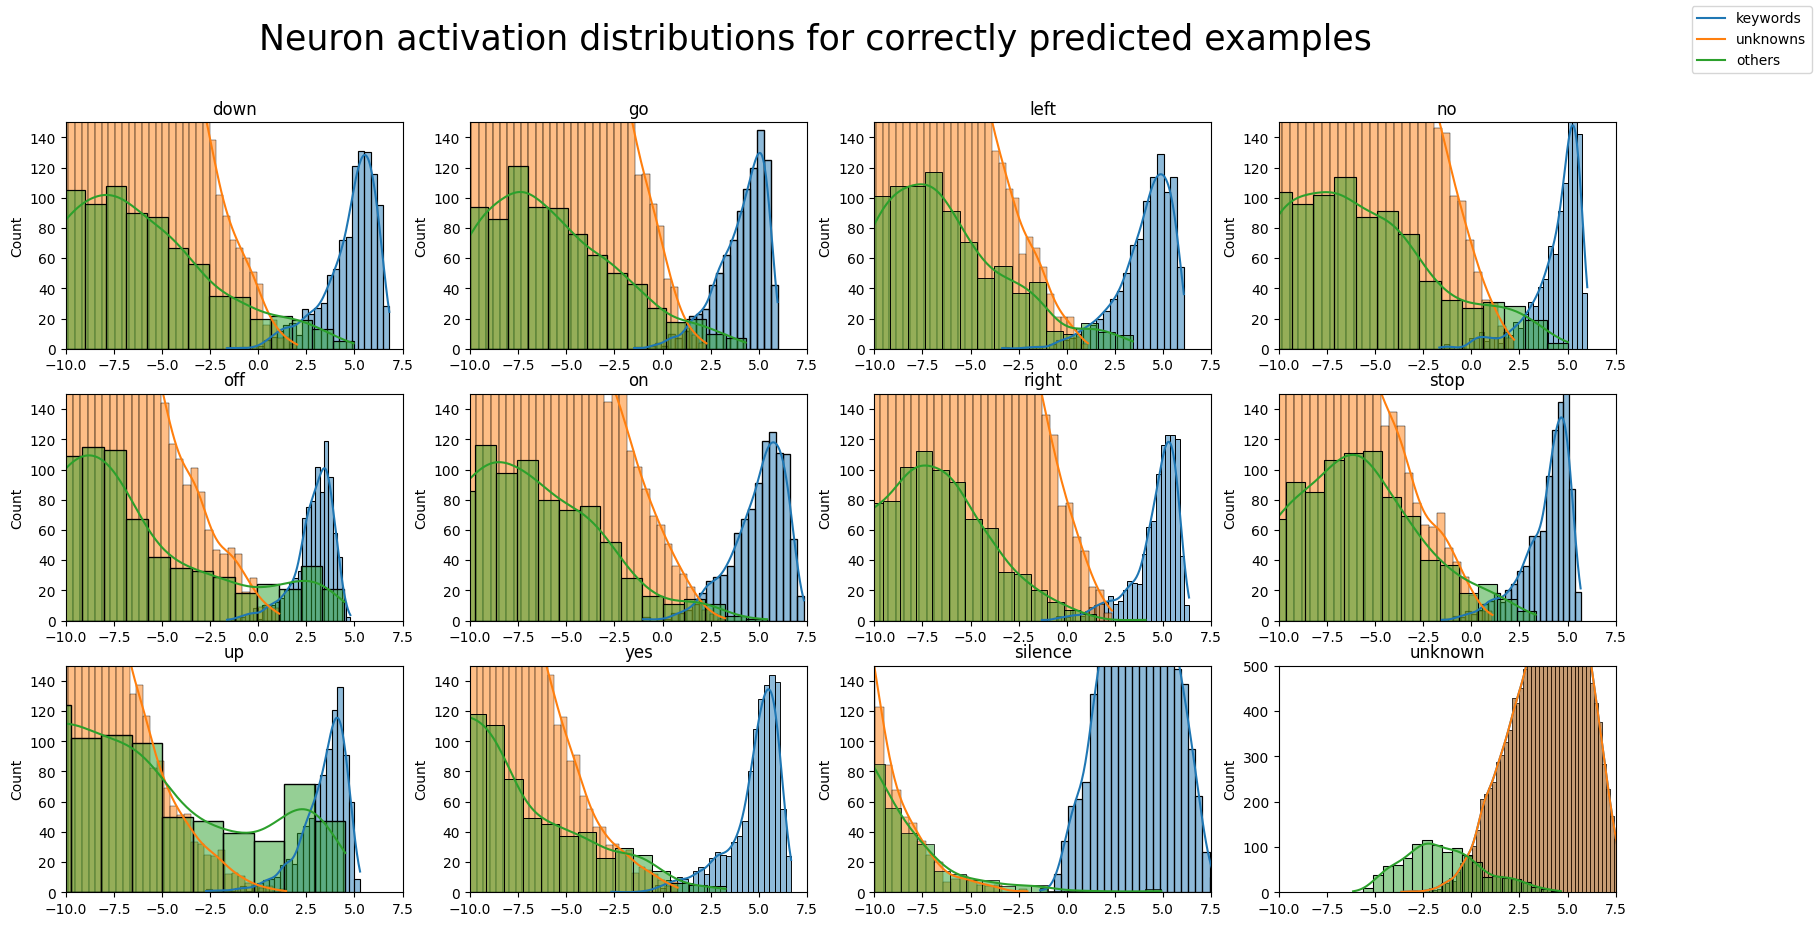

In [165]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle("Neuron activation distributions for correctly predicted examples", fontsize=25)
for i in range(3):
    for j in range(4):
        sns.histplot(outputs_all[(targets_all==i*4+j) & (np.argmax(outputs_all, axis=1)==i*4+j), i*4+j], kde=True, ax = axs[i,j]) #activation for each keyword
        sns.histplot(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)==11), i*4+j], kde=True, ax = axs[i,j]) #activation for unknowns 
        sns.histplot(outputs_all[(targets_all!=i*4+j) & (targets_all!=11) & (np.argmax(outputs_all, axis=1)!=targets_all), i*4+j], kde=True, ax = axs[i,j]) #activation for other keywords
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-10, 7.5)
        axs[i, j].set_ylim(0, 150)
fig.legend(['keywords', 'unknowns', 'others'])
axs[i, j].set_ylim(0, 500)

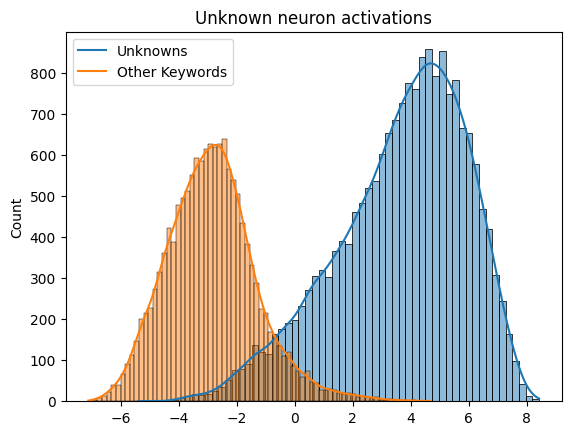

In [17]:
sns.histplot(outputs_all[(targets_all==11), 11], kde=True) #activation for unknowns 
sns.histplot(outputs_all[(targets_all!=11), 11], kde=True) #activation for rather than unknowns
plt.title('Unknown neuron activations')
plt.legend(['Unknowns', 'Other Keywords'])

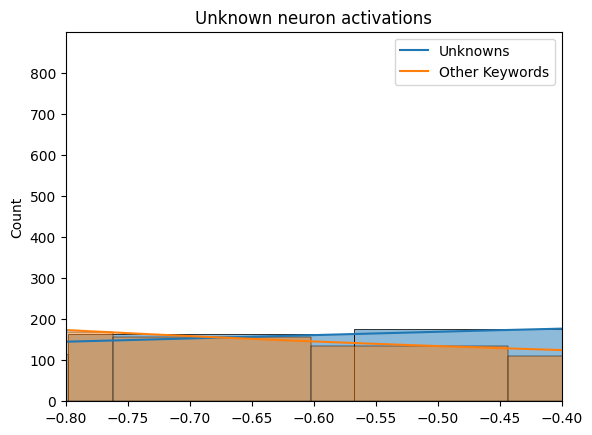

In [27]:
sns.histplot(outputs_all[(targets_all==11), 11], kde=True) #activation for unknowns 
sns.histplot(outputs_all[(targets_all!=11), 11], kde=True) #activation for rather than unknowns
plt.xlim(-0.8,-0.4)
plt.title('Unknown neuron activations')
plt.legend(['Unknowns', 'Other Keywords'])

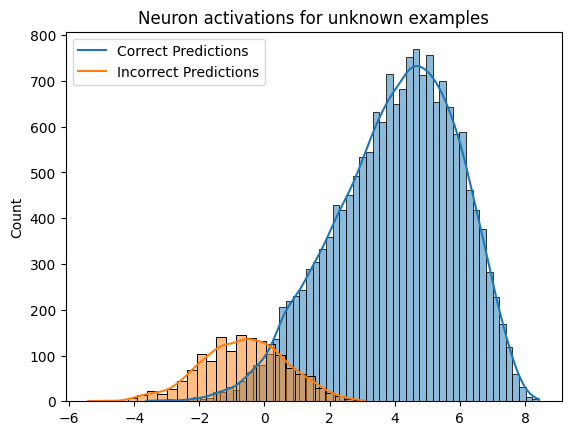

In [14]:
sns.histplot(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)==11), 11], kde=True) #activation for unknowns 
sns.histplot(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)!=11), 11], kde=True) #activation for rather than unknowns
plt.title('Neuron activations for unknown examples')
plt.legend(['Correct Predictions', 'Incorrect Predictions'])

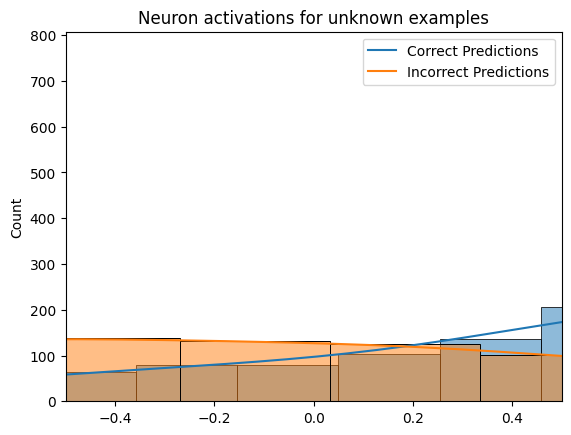

In [74]:
sns.histplot(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)==11), 11], kde=True) #activation for unknowns 
sns.histplot(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)!=11), 11], kde=True) #activation for rather than unknowns
plt.xlim(-0.5,0.5)
plt.title('Neuron activations for unknown examples')
plt.legend(['Correct Predictions', 'Incorrect Predictions'])

### kucuk not

(0.0, 500.0)

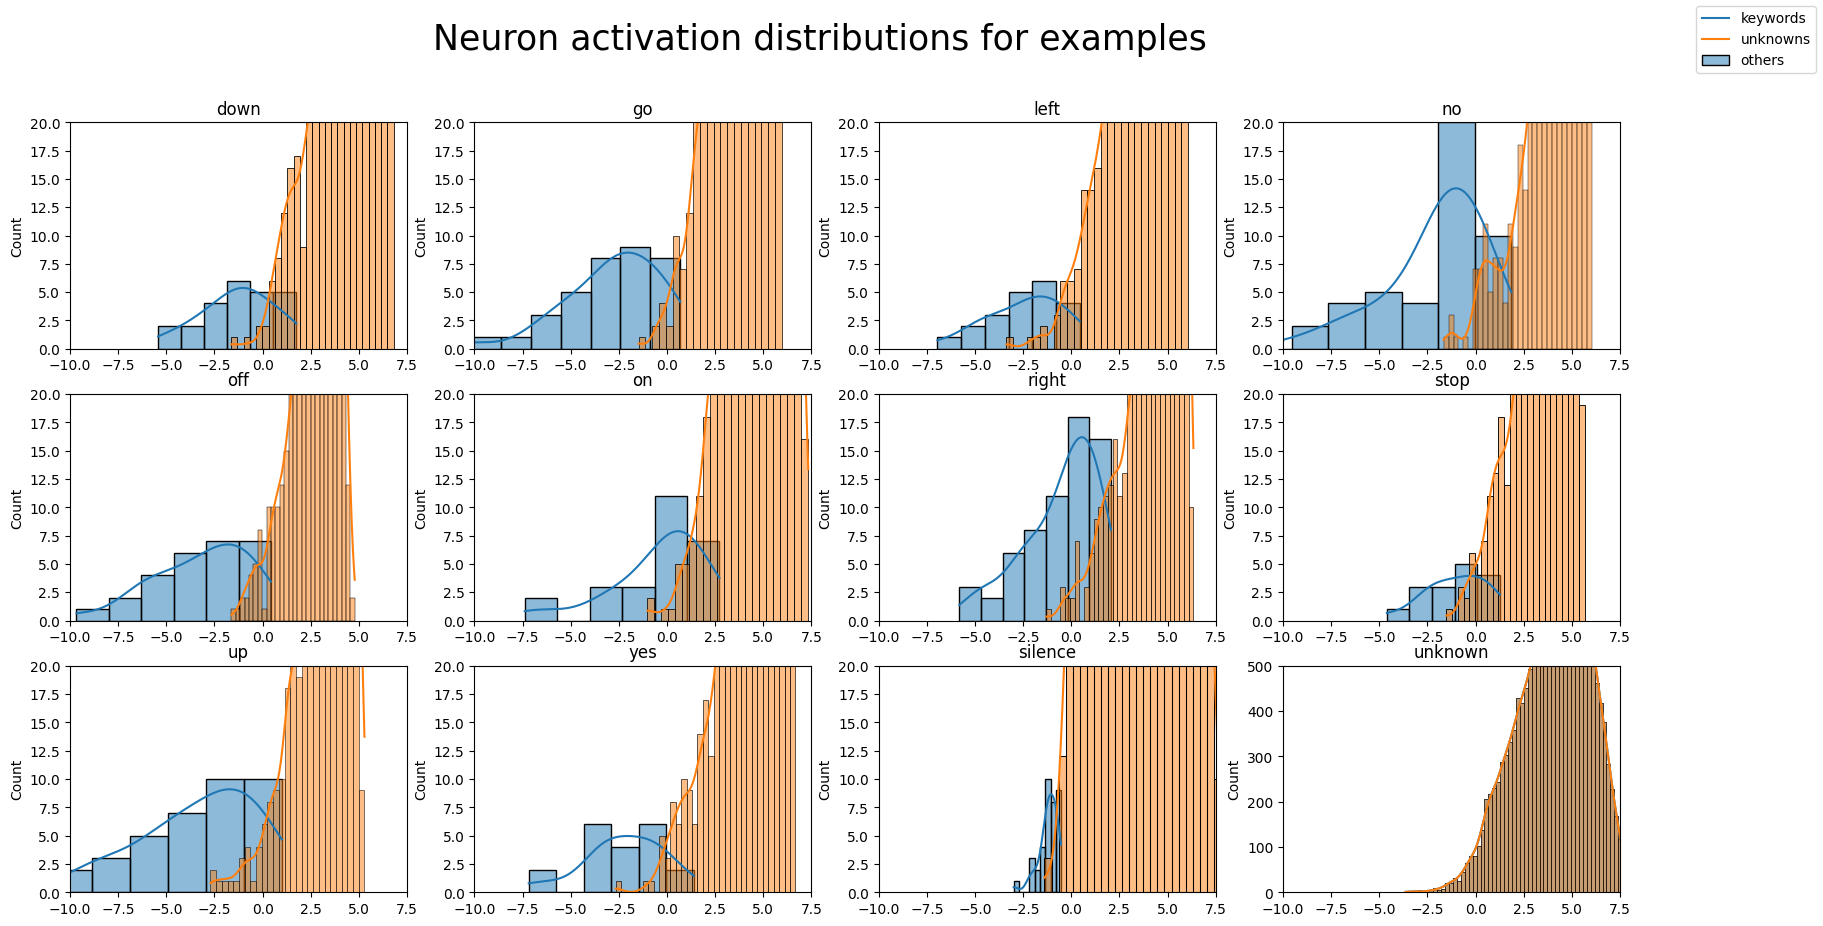

In [15]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle("Neuron activation distributions for examples", fontsize=25)
for i in range(3):
    for j in range(4):
        sns.histplot(outputs_all[(targets_all==i*4+j) & (np.argmax(outputs_all, axis=1)==11), i*4+j], kde=True, ax = axs[i,j]) #activation for other keywords
        sns.histplot(outputs_all[(targets_all==i*4+j) & (np.argmax(outputs_all, axis=1)==i*4+j), i*4+j], kde=True, ax = axs[i,j]) #activation for other keywords
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-10, 7.5)
        axs[i, j].set_ylim(0, 20)
fig.legend(['keywords', 'unknowns', 'others'])
axs[i, j].set_ylim(0, 500)

(0.0, 500.0)

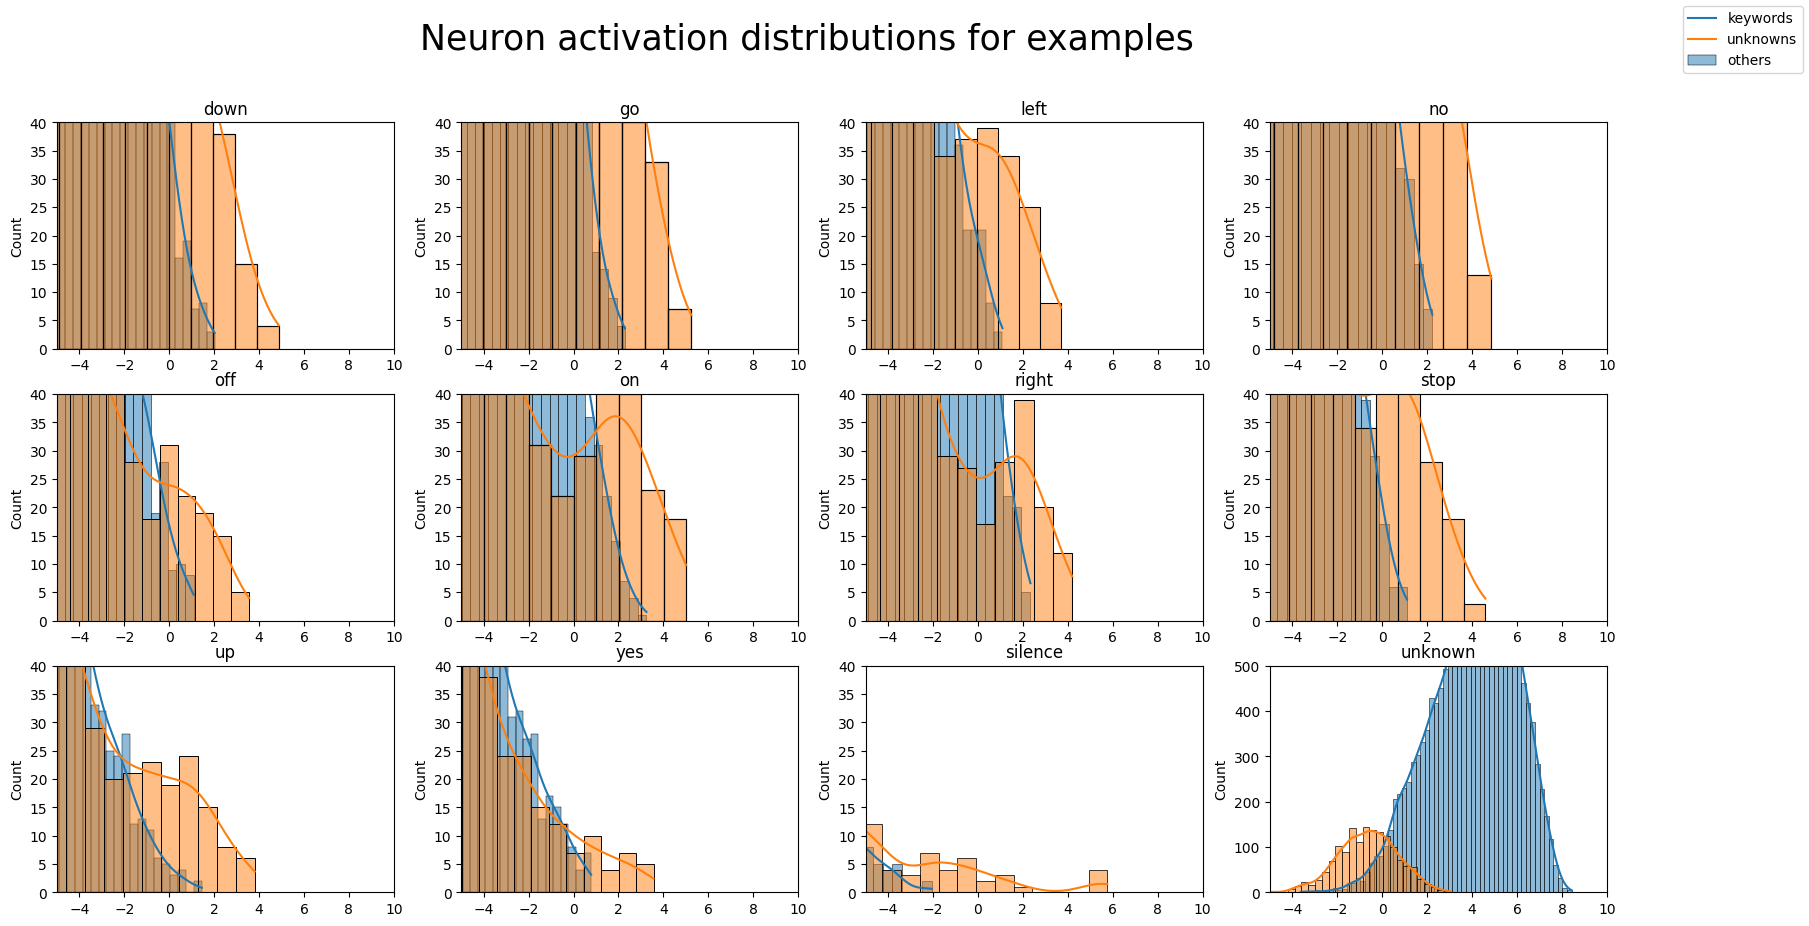

In [16]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle("Neuron activation distributions for examples", fontsize=25)
for i in range(3):
    for j in range(4):
        sns.histplot(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)==11), i*4+j], kde=True, ax = axs[i,j]) #activation for each keyword
        sns.histplot(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)!=11), i*4+j], kde=True, ax = axs[i,j]) #activation for unknowns 
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-5, 10)
        axs[i, j].set_ylim(0, 40)
fig.legend(['keywords', 'unknowns', 'others'])
axs[i, j].set_ylim(0, 500)

(0.0, 500.0)

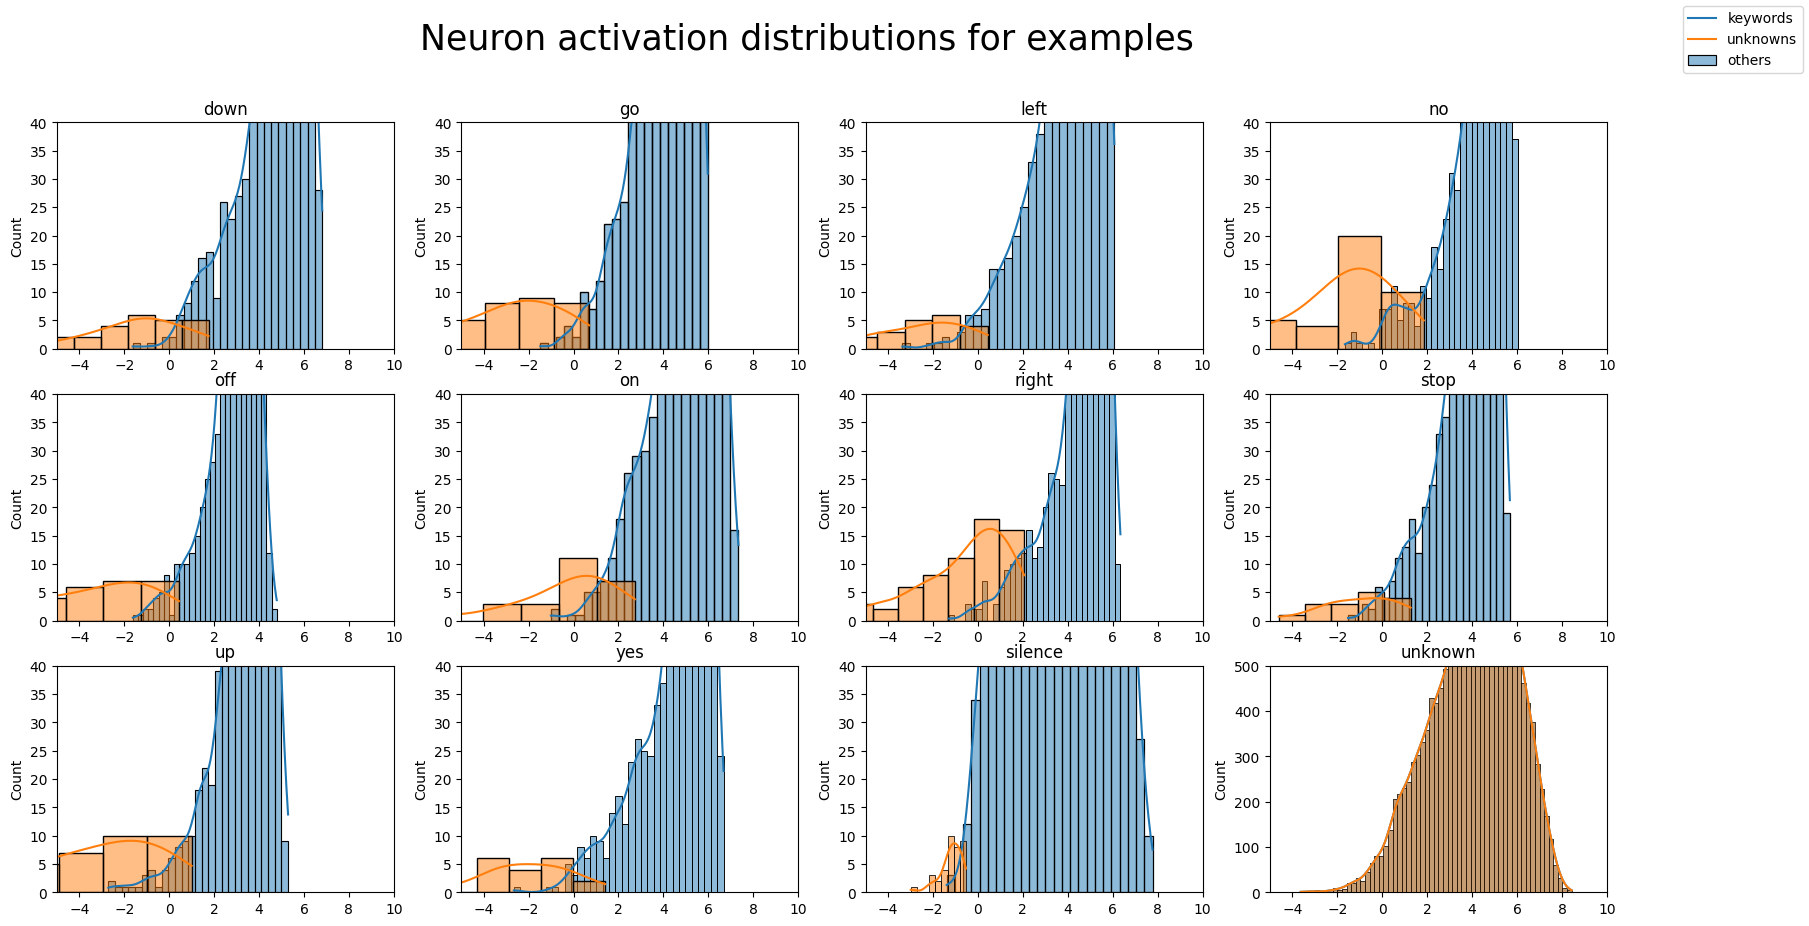

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle("Neuron activation distributions for examples", fontsize=25)
for i in range(3):
    for j in range(4):
        sns.histplot(outputs_all[(targets_all==i*4+j) & (np.argmax(outputs_all, axis=1)==i*4+j), i*4+j], kde=True, ax = axs[i,j]) #activation for each keyword
        sns.histplot(outputs_all[(targets_all==i*4+j) & (np.argmax(outputs_all, axis=1)==11), i*4+j], kde=True, ax = axs[i,j]) #activation for unknowns 
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-5, 10)
        axs[i, j].set_ylim(0, 40)
fig.legend(['keywords', 'unknowns', 'others'])
axs[i, j].set_ylim(0, 500)

## plots

(0.0, 500.0)

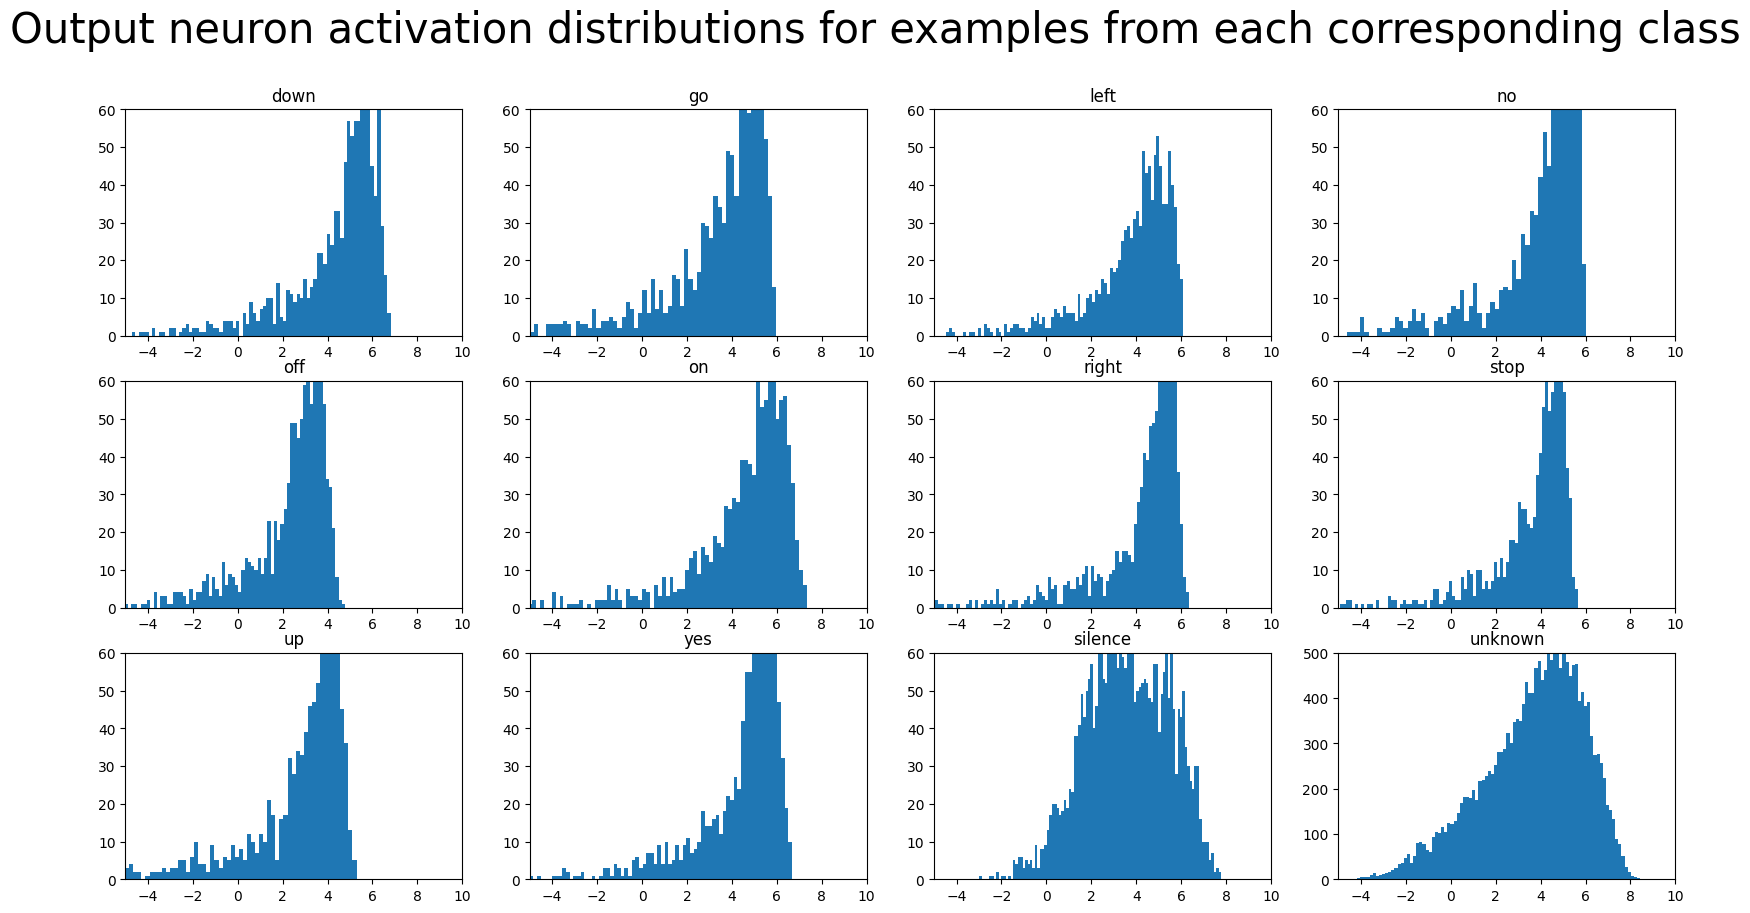

In [11]:
# plot the distribution of each output activation with the corresponding label in a 3x4 grid
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle("Output neuron activation distributions for examples from each corresponding class", fontsize=30)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[targets_all==i*4+j,i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-5, 10)
        axs[i, j].set_ylim(0, 60)
axs[i, j].set_ylim(0, 500)

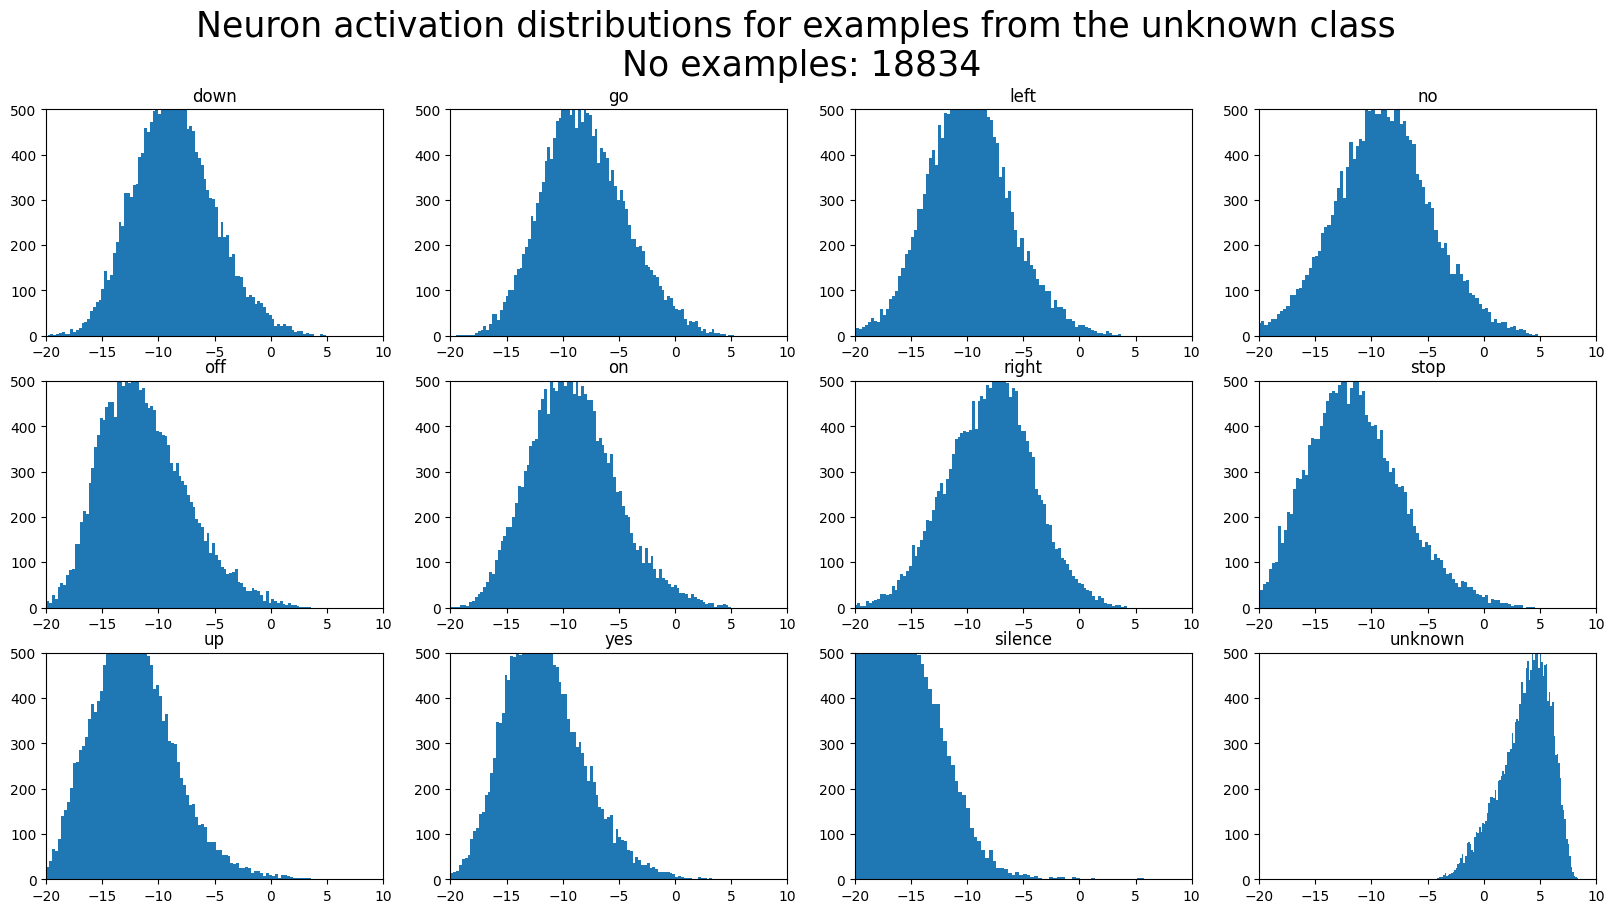

In [12]:
# plot the distribution of each output activation when the label is the unknown class in a 3x4 grid
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f"Neuron activation distributions for examples from the unknown class\n No examples: {(targets_all==11).sum()}", fontsize=25)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[targets_all==11,i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-20, 10)
        axs[i, j].set_ylim(0, 500)

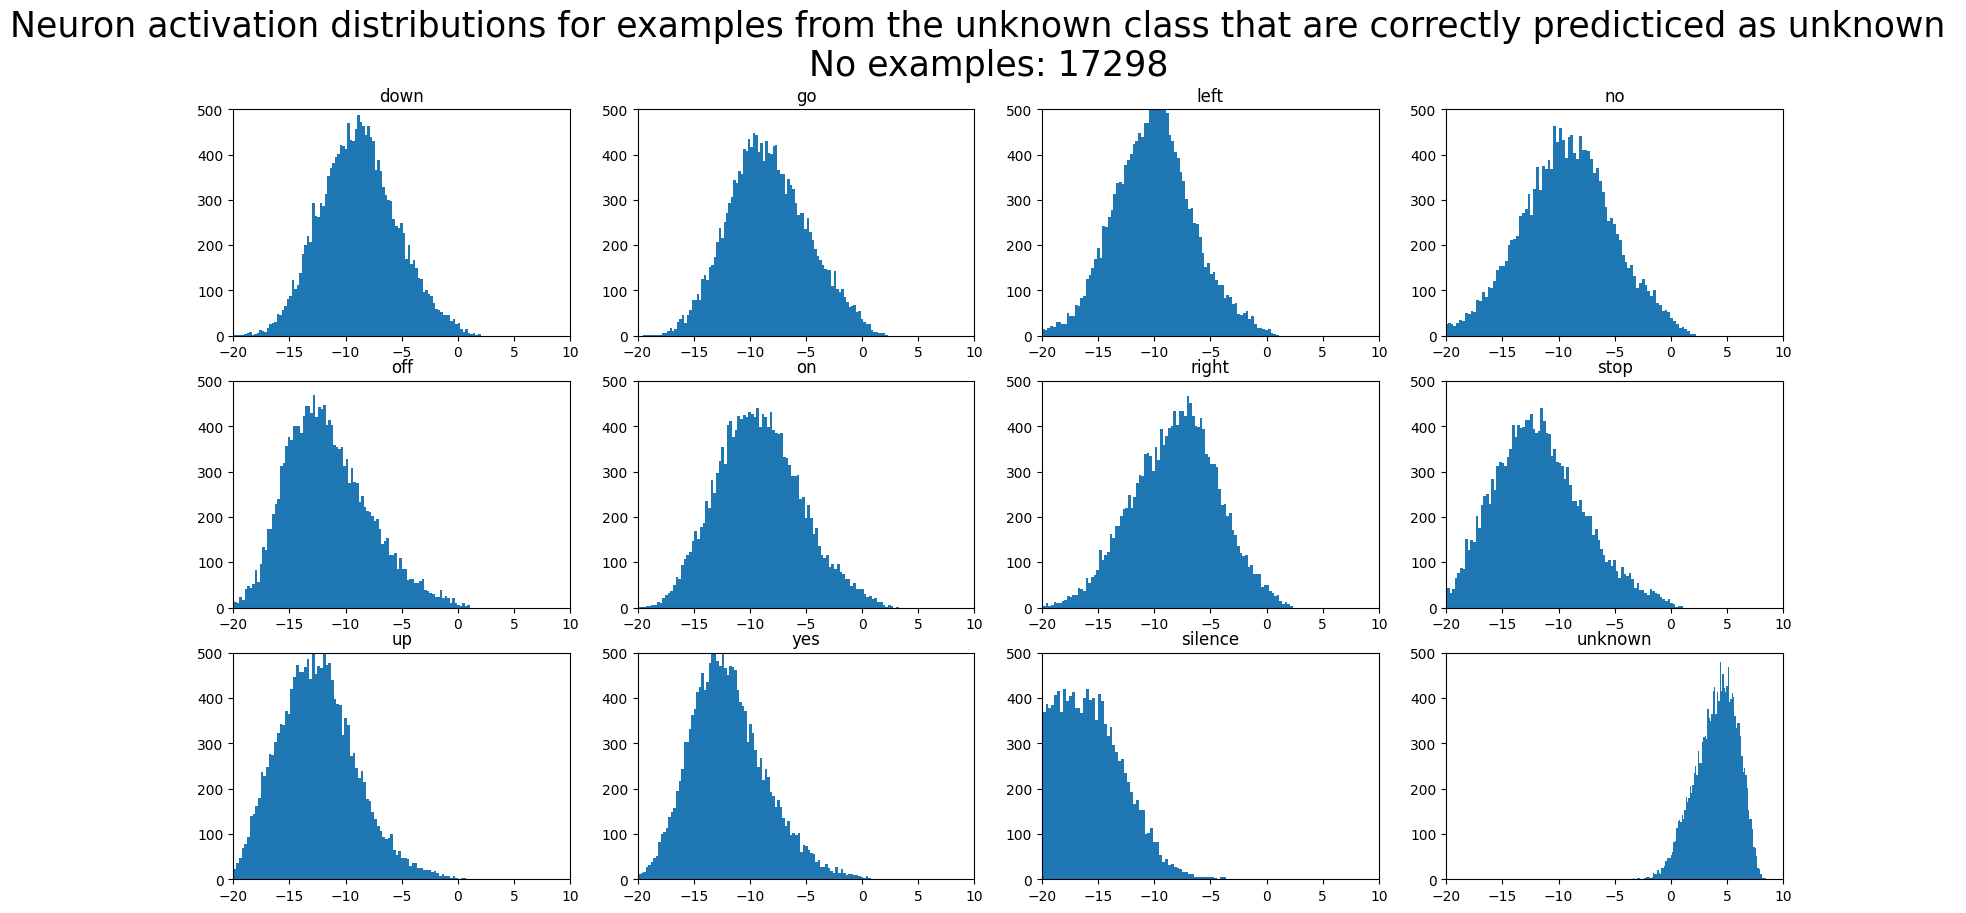

In [13]:
# plot the distribution of each output activation when the label is the unknown class and the model predicts the unknown class in a 3x4 grid
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f"Neuron activation distributions for examples from the unknown class that are correctly predicticed as unknown \n No examples: {((targets_all==11) & (np.argmax(outputs_all, axis=1)==11)).sum()}", fontsize=25)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)==11),i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-20, 10)
        axs[i, j].set_ylim(0, 500)

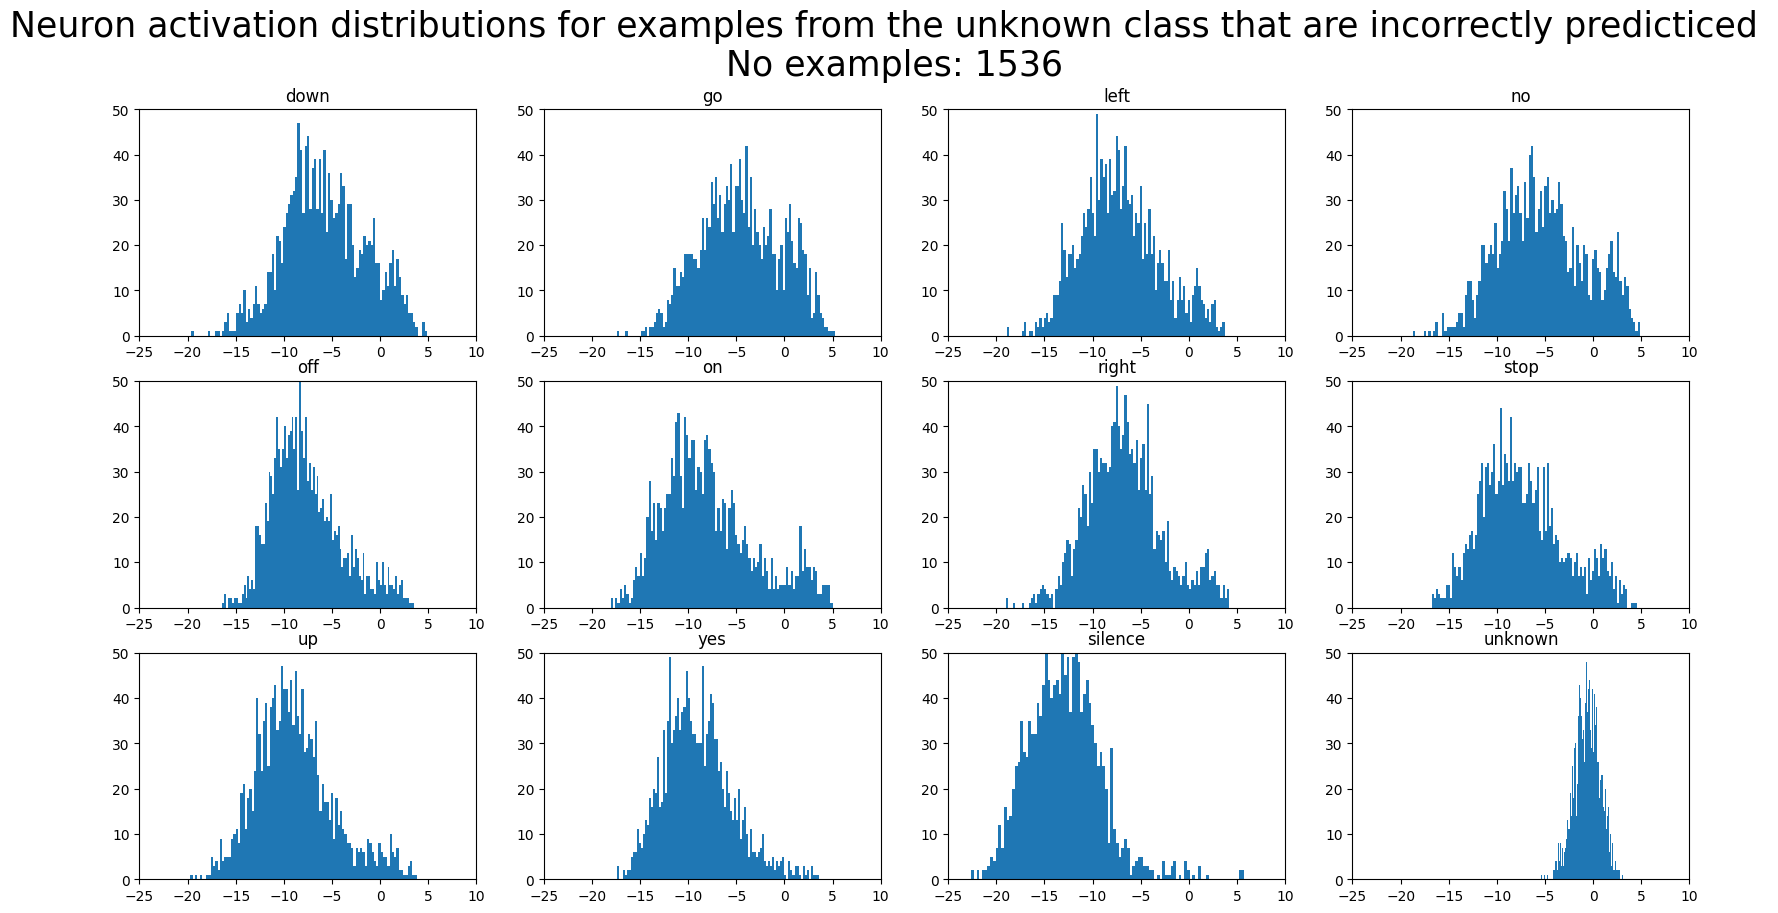

In [14]:
# plot the distribution of each output activation when the label is the unknown class and the model does not predict the unknown class in a 3x7 grid
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f"Neuron activation distributions for examples from the unknown class that are incorrectly predicticed \n No examples: {((targets_all==11) & (np.argmax(outputs_all, axis=1)!=11)).sum()}", fontsize=25)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[(targets_all==11) & (np.argmax(outputs_all, axis=1)!=11),i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-25, 10)
        axs[i, j].set_ylim(0, 50)

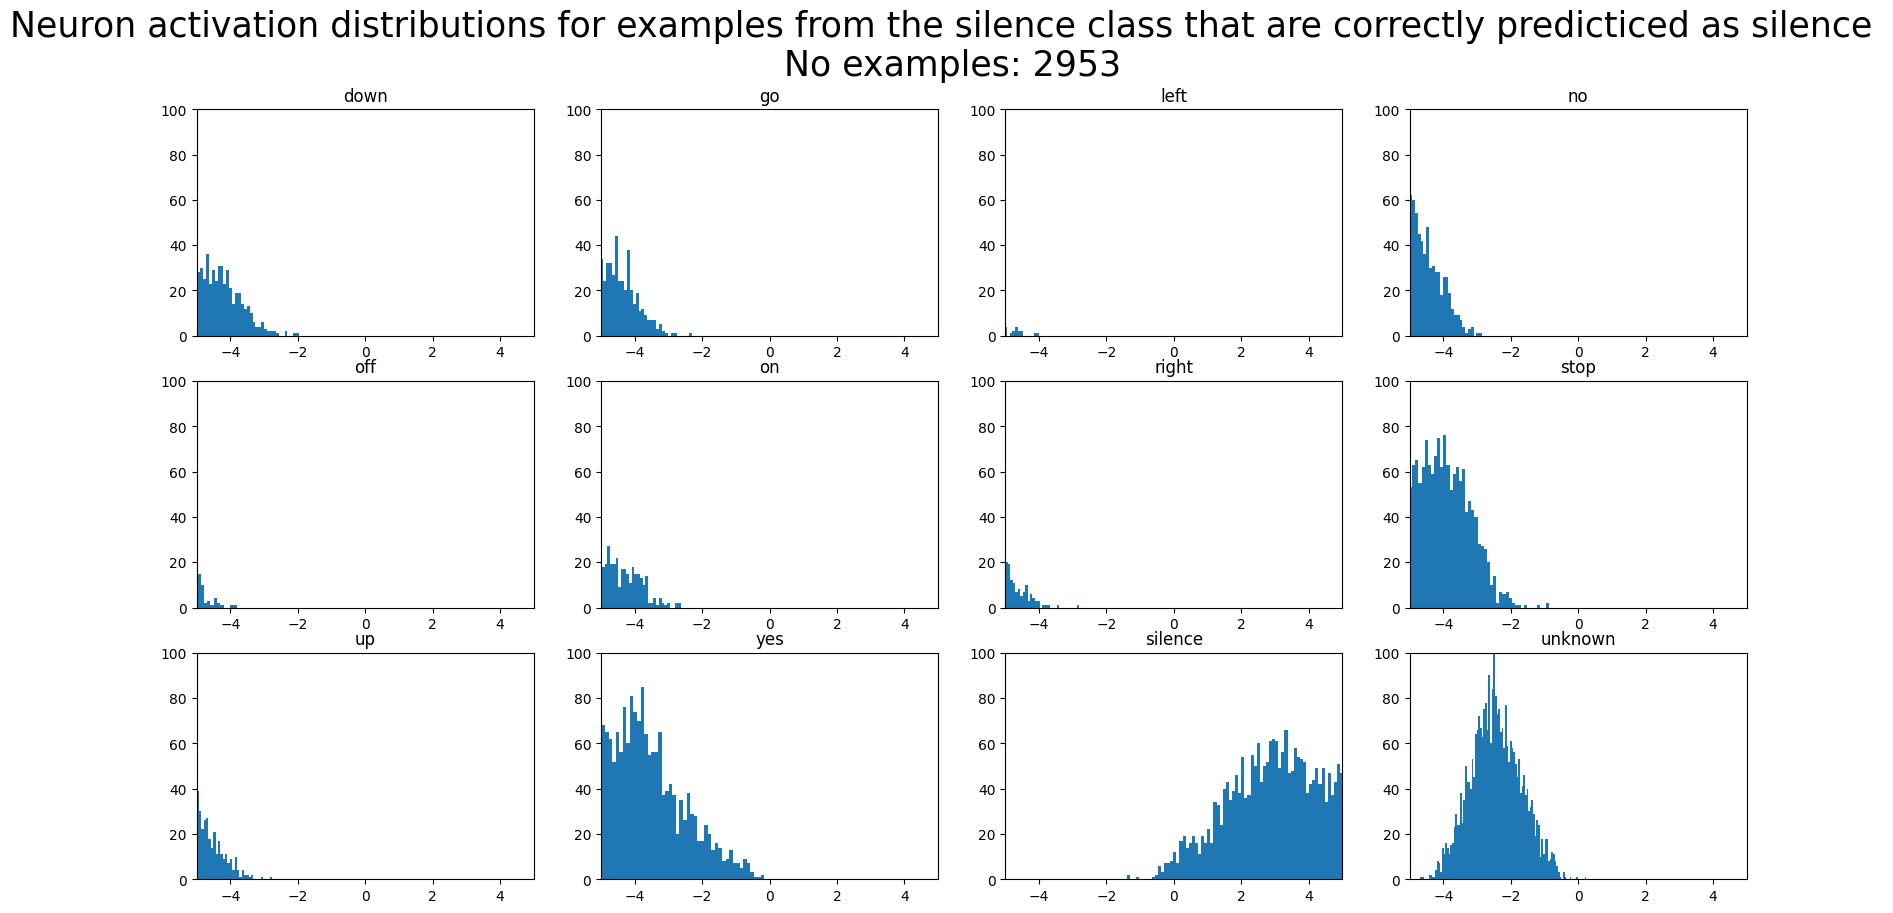

In [15]:
# plot the distribution of each output activation when the label is the unknown class and the model predicts the unknown class in a 3x4 grid
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f"Neuron activation distributions for examples from the silence class that are correctly predicticed as silence \n No examples: {((targets_all==10) & (np.argmax(outputs_all, axis=1)==10)).sum()}", fontsize=25)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[(targets_all==10) & (np.argmax(outputs_all, axis=1)==10),i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-5, 5)
        axs[i, j].set_ylim(0, 100)

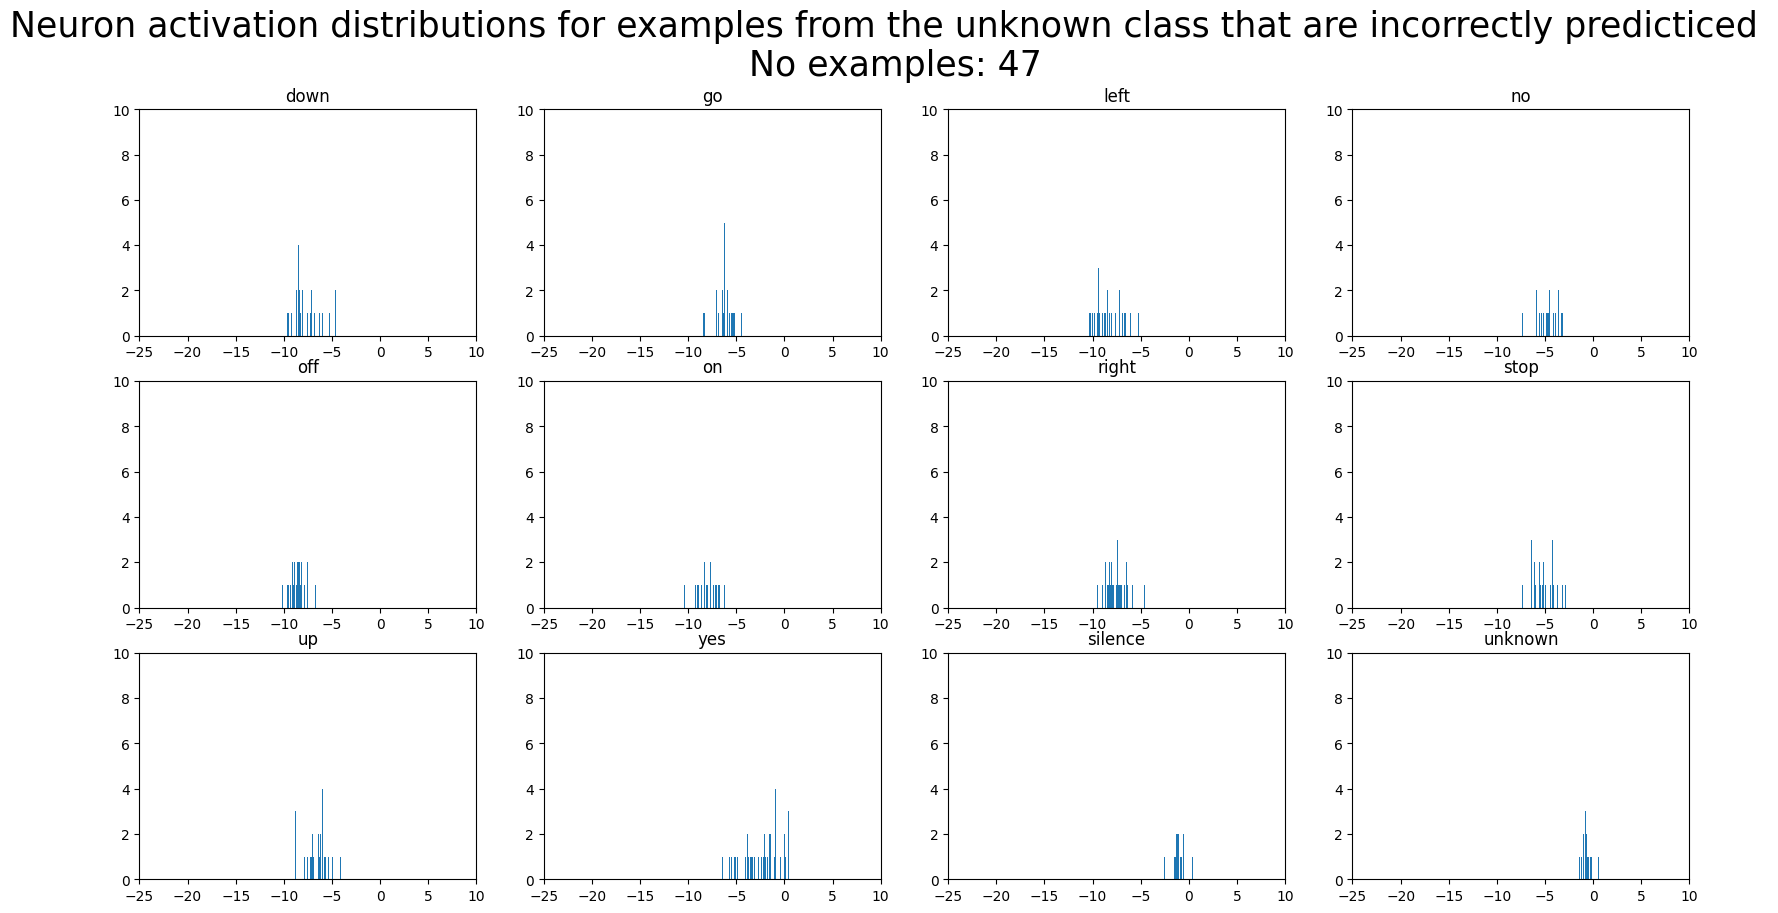

In [16]:
# plot the distribution of each output activation when the label is the unknown class and the model does not predict the unknown class in a 3x7 grid
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f"Neuron activation distributions for examples from the unknown class that are incorrectly predicticed \n No examples: {((targets_all==10) & (np.argmax(outputs_all, axis=1)!=10)).sum()}", fontsize=25)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[(targets_all==10) & (np.argmax(outputs_all, axis=1)!=10),i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-25, 10)
        axs[i, j].set_ylim(0, 10)

(0.0, 500.0)

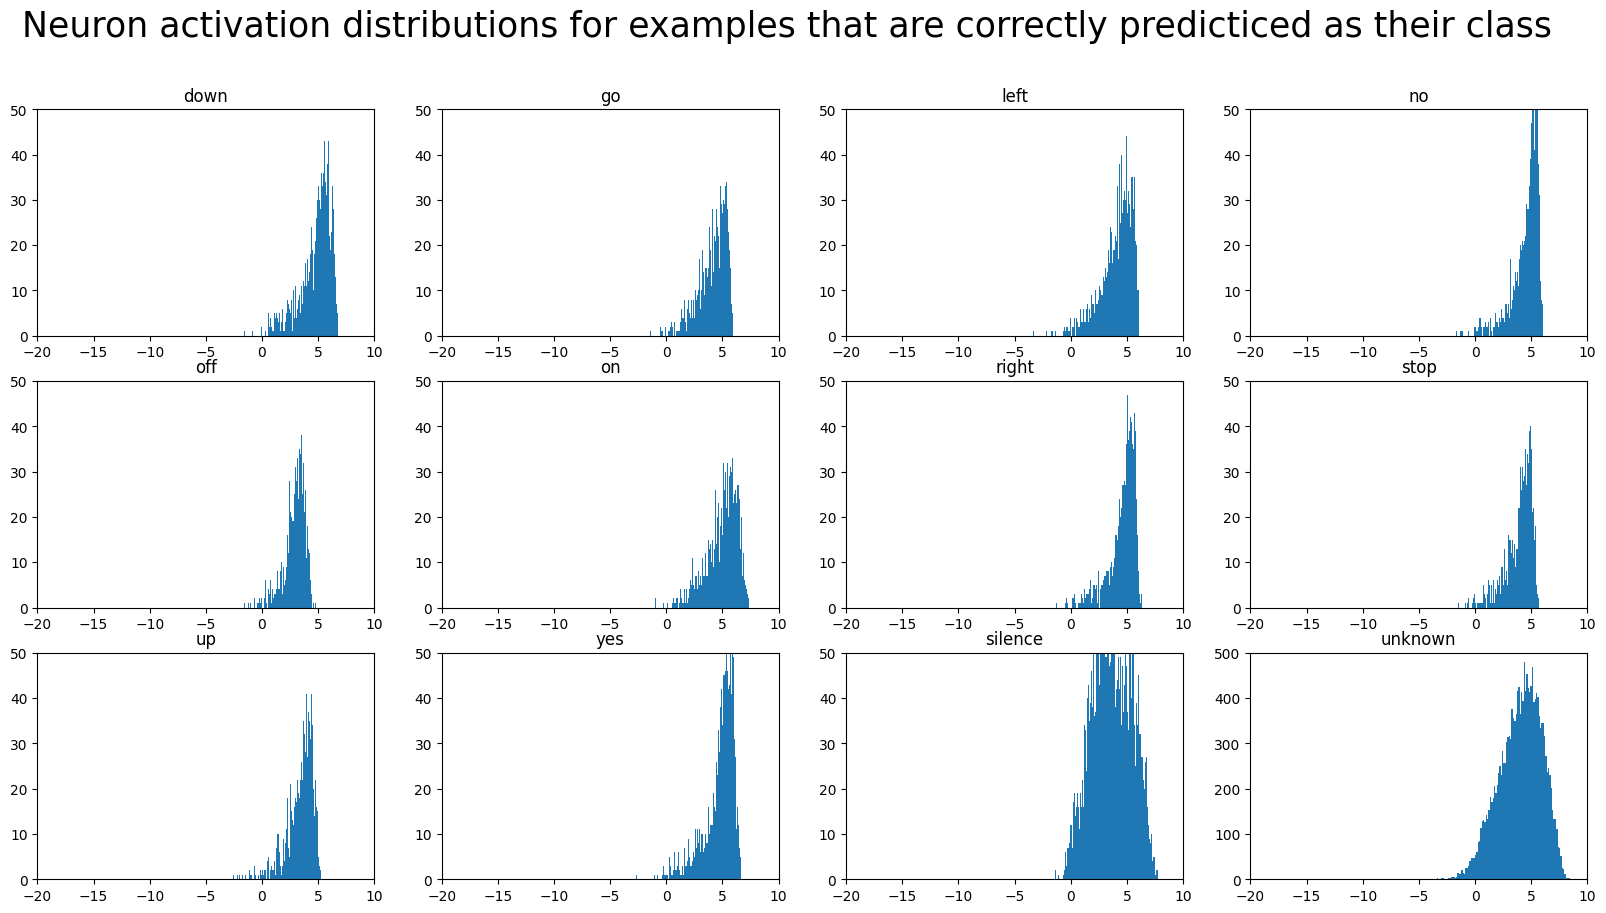

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle("Neuron activation distributions for examples that are correctly predicticed as their class", fontsize=25)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[(targets_all==i*4+j) & (np.argmax(outputs_all, axis=1)==i*4+j),i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-20, 10)
        axs[i, j].set_ylim(0, 50)
axs[i, j].set_ylim(0, 500)

(0.0, 500.0)

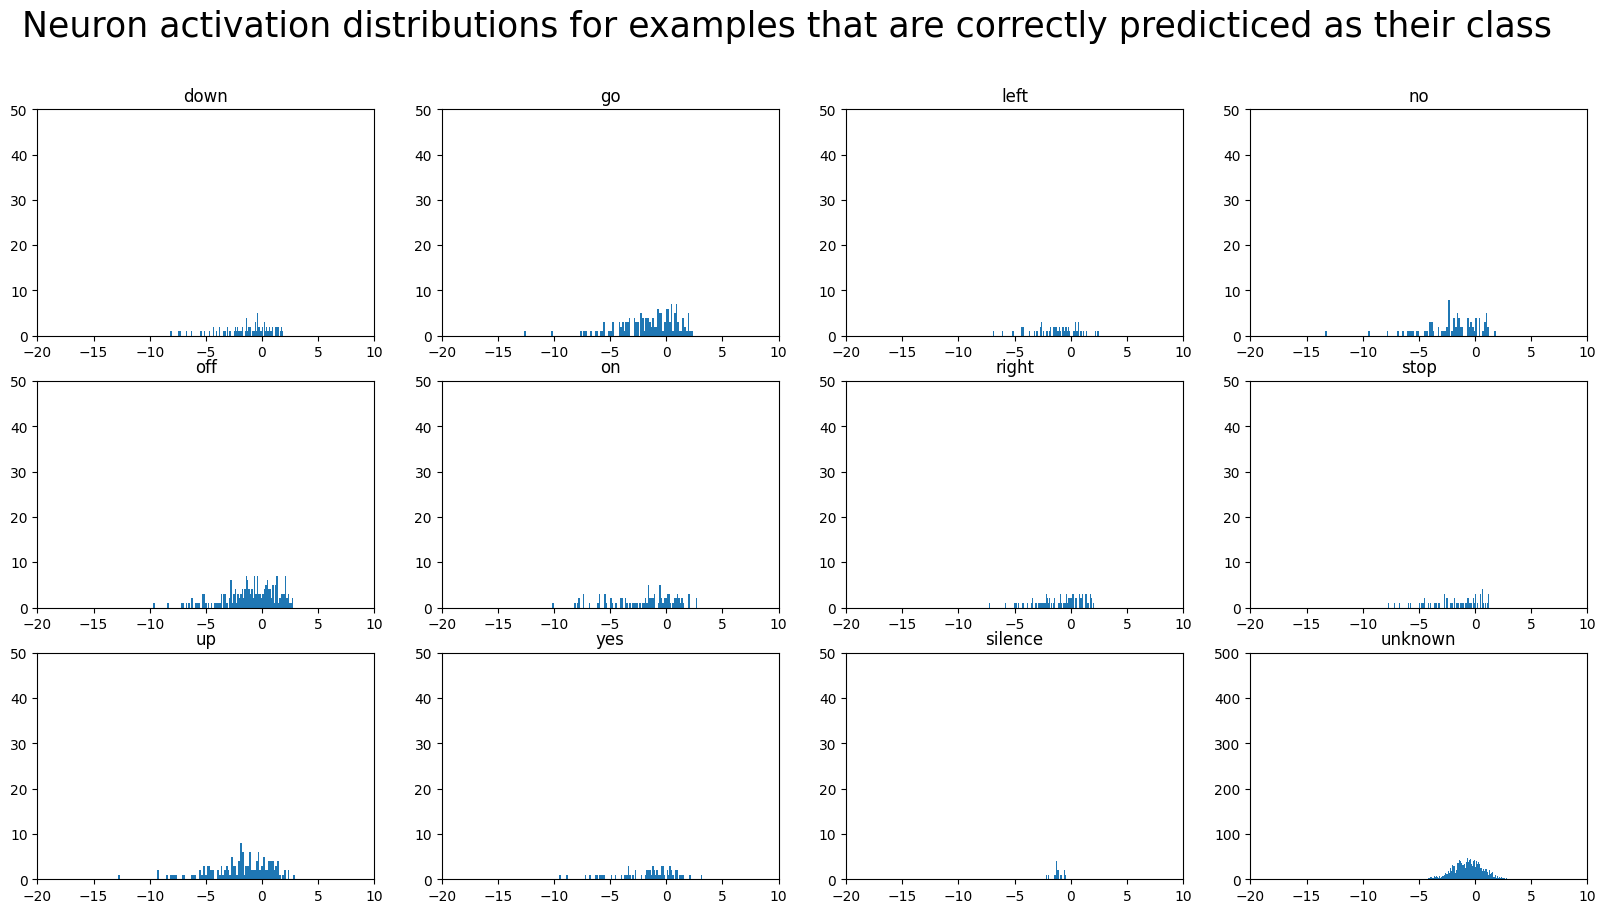

In [18]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle("Neuron activation distributions for examples that are correctly predicticed as their class", fontsize=25)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[(targets_all==i*4+j) & (np.argmax(outputs_all, axis=1)!=i*4+j),i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-20, 10)
        axs[i, j].set_ylim(0, 50)
axs[i, j].set_ylim(0, 500)

(0.0, 500.0)

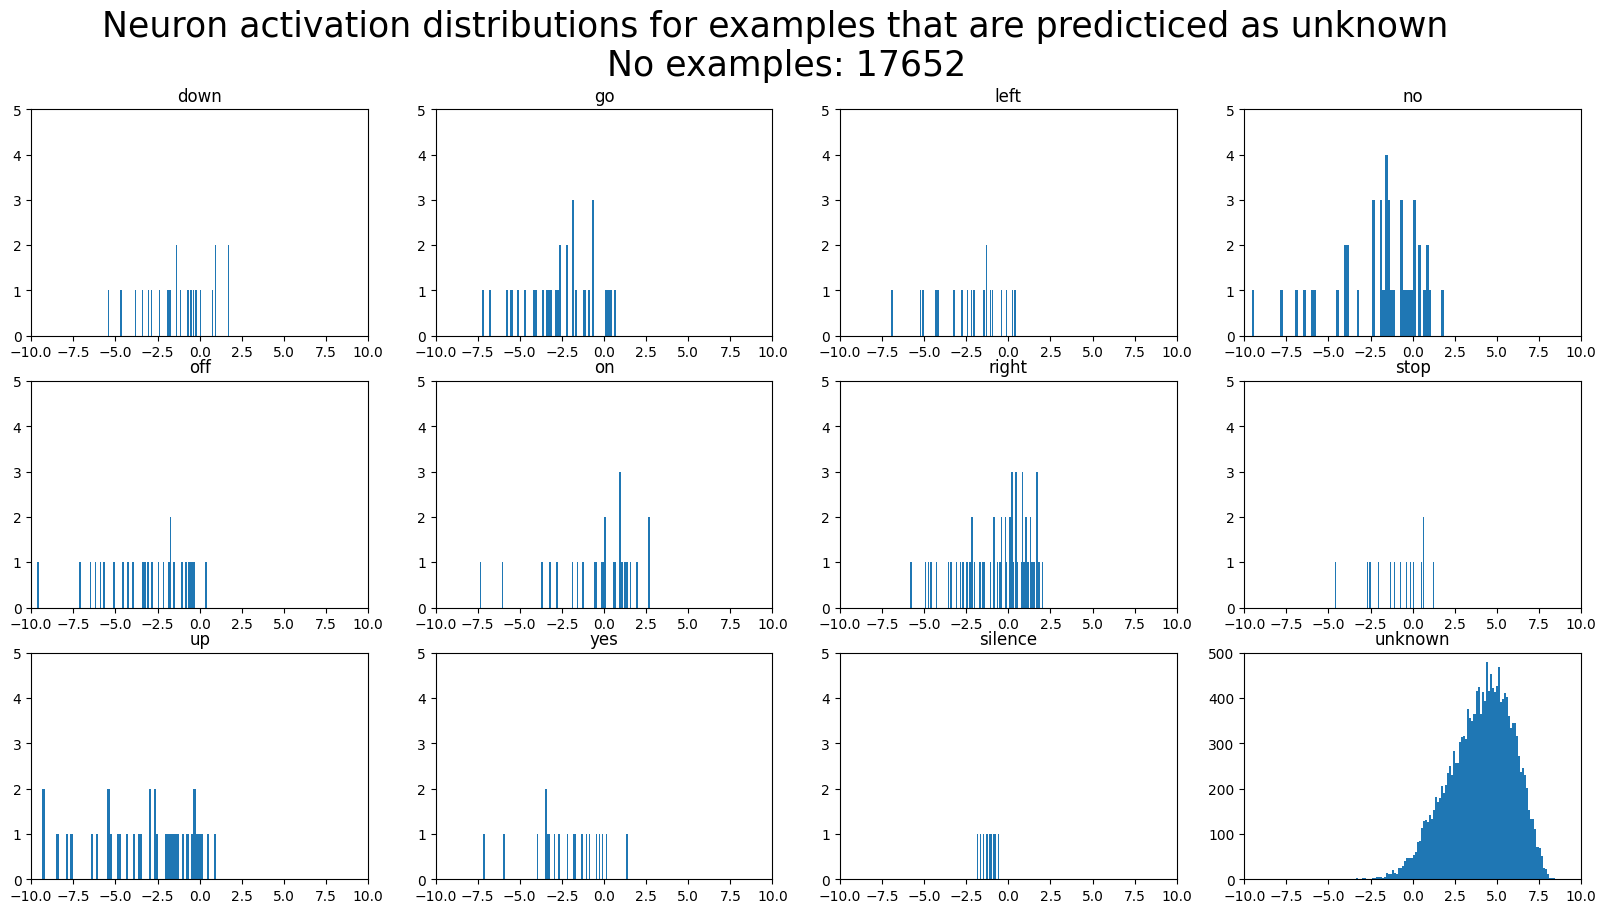

In [19]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f"Neuron activation distributions for examples that are predicticed as unknown \n No examples: {((np.argmax(outputs_all, axis=1)==11)).sum()}", fontsize=25)
for i in range(3):
    for j in range(4):
        axs[i, j].hist(outputs_all[(targets_all==i*4+j) & (np.argmax(outputs_all, axis=1)==11),i*4+j], bins=100)
        axs[i, j].set_title(classes[i*4+j])
        axs[i, j].set_xlim(-10, 10)
        axs[i, j].set_ylim(0, 5)
axs[i, j].set_ylim(0, 500)

## validation set

In [72]:
model.eval()
model.to(device)
classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
confusion = tnt.ConfusionMeter(len(classes))
outputs_all = np.zeros((len(val_dataset), len(classes)))
targets_all = np.zeros((len(val_dataset)))
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        classerr.add(outputs, targets)
        confusion.add(outputs, targets)
        #print("Batch: [",batch_idx*256 ,"/", len(val_dataset),"]")
        acc = classerr.value()[0]
        #print("Accuracy: ", acc)
        outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
        targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
    print("Total Accuracy: ", acc)

Total Accuracy:  92.05293992653978


In [46]:
np.disp(confusion.value())

[[ 1049    24     0    21     0     3     1     7     0     0     2    24]
 [   51   964     1    47     0     1     3     5     3     4     2    35]
 [    1     1   992    18     1     0     4     2     3    13     0    21]
 [   10    17    10  1131     0     0     1     2     1     0     0    46]
 [    1     5     1     0   924    27     1    16   115     2     0    27]
 [    7     2     0     4    32   996     1     0    17     4     0    26]
 [    1     1     9     4     0     2  1005     1     1     0     1    64]
 [    4     9     0     1     5     0     2   985    24     3     1    16]
 [    0     5     6     1    57     6     1    30   904     0     2    38]
 [    3     6    27     7     1     0     2     0     1  1124     0    20]
 [    0     0     0     0     0     0     0     0     0    10  2953    37]
 [  183   294   128   257    90   160   133   155    76    39    21 17298]]


In [140]:
new_val_classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
new_val_confusion = tnt.ConfusionMeter(len(classes))
outputs_all = np.zeros((len(val_dataset), len(classes)))
targets_all = np.zeros((len(val_dataset)))
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        for i in range(len(outputs)):
            if (outputs.max(1)[0][i] != outputs[i][-1]):
                if (outputs.max(1)[0][i] < 2):
                    if (outputs[i][-1] > 0.2):
                        outputs[i, len(classes)-1] += 100

        '''
        for i in range(len(outputs)):
            if (outputs.max(1)[0][i] == outputs[i][-1]):
                if (outputs.max(1)[0][i] < -0.68):
                    outputs[i, len(classes)-1] -= 100
        '''

        new_val_classerr.add(outputs, targets)
        new_val_confusion.add(outputs, targets)
        #print("Batch: [",batch_idx*256 ,"/", len(val_dataset),"]")
        new_val_acc = new_val_classerr.value()[0]
        #print("Accuracy: ", acc)
        outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
        targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
    print("Total Accuracy: ", new_val_acc)

Total Accuracy:  92.5629116959597


In [141]:
np.disp(new_val_confusion.value())

[[ 1041    23     0    21     0     2     1     6     0     0     2    35]
 [   48   958     1    46     0     1     3     5     3     4     2    45]
 [    1     1   988    16     1     0     4     2     3    13     0    27]
 [   10    17    10  1123     0     0     1     2     1     0     0    54]
 [    1     5     1     0   923    27     1    16   115     2     0    28]
 [    7     2     0     4    31   990     1     0    17     4     0    33]
 [    1     1     7     4     0     2   993     1     1     0     1    78]
 [    4     9     0     1     5     0     2   980    24     3     1    21]
 [    0     5     6     1    57     6     1    29   903     0     2    40]
 [    3     6    26     7     1     0     2     0     1  1122     0    23]
 [    0     0     0     0     0     0     0     0     0    10  2952    38]
 [  149   251   113   214    85   135   101   140    70    35    21 17520]]


In [112]:
sum = 0
sum_unknowns = 0
for i in range(confusion.value().shape[0] - 1):
    sum += confusion.value()[i,i]
    sum_unknowns += confusion.value()[i,i]

sum_unknowns -= confusion.value()[10,10]

print(f'Accuracy in general {acc}')
print(f'Accuracy for unknowns and labeled as unknowns {(confusion.value()[-1,-1] / (confusion.value()[-1,:].sum() + confusion.value()[:-1,-1].sum())) * 100}')
print(f'Accuracy for silence and labeled as silence {(confusion.value()[-2,-2] / (confusion.value()[-2,:].sum() + confusion.value()[:,-2].sum() - confusion.value()[-2,-2].sum())) * 100}')
print(f'Accuracy without unknowns and labeled as unknowns {(sum / (confusion.value()[:-1,:-1].sum())) * 100}')
print(f'Accuracy for keywords without unknown class & silence class {(sum_unknowns / (np.sum(confusion.value()) - np.sum(confusion.value()[-2:,:]) - np.sum(confusion.value()[:-2,-2:]))) * 100}')
print(f'Accuracy for unknowns {(confusion.value()[-1,-1] / (confusion.value()[-1,:].sum())) * 100}')

print('\nNew Method Results\n')

sum = 0
sum_unknowns = 0
for i in range(new_val_confusion.value().shape[0] - 1):
    sum += new_val_confusion.value()[i,i]
    sum_unknowns += new_val_confusion.value()[i,i]

sum_unknowns -= new_val_confusion.value()[10,10]

print(f'Accuracy in general {new_val_acc}')
print(f'Accuracy for unknowns and labeled as unknowns {(new_val_confusion.value()[-1,-1] / (new_val_confusion.value()[-1,:].sum() + new_val_confusion.value()[:-1,-1].sum())) * 100}')
print(f'Accuracy for silence and labeled as silence {(new_val_confusion.value()[-2,-2] / (new_val_confusion.value()[-2,:].sum() + new_val_confusion.value()[:,-2].sum() - new_val_confusion.value()[-2,-2].sum())) * 100}')
print(f'Accuracy without unknowns and labeled as unknowns {(sum / (new_val_confusion.value()[:-1,:-1].sum())) * 100}')
print(f'Accuracy for keywords without unknown class & silence class {(sum_unknowns / (np.sum(new_val_confusion.value()) - np.sum(new_val_confusion.value()[-2:,:]) - np.sum(new_val_confusion.value()[:-2,-2:]))) * 100}')
print(f'Accuracy for unknowns {(new_val_confusion.value()[-1,-1] / (new_val_confusion.value()[-1,:].sum())) * 100}')


Accuracy in general 92.05293992653978
Accuracy for unknowns and labeled as unknowns 90.15009380863039
Accuracy for silence and labeled as silence 97.49092109607132
Accuracy without unknowns and labeled as unknowns 94.70737913486005
Accuracy for keywords without unknown class & silence class 93.41617210682493
Accuracy for unknowns 91.8445364765849

New Method Results

Accuracy in general 92.5629116959597
Accuracy for unknowns and labeled as unknowns 90.98462816784378
Accuracy for silence and labeled as silence 97.45790689996699
Accuracy without unknowns and labeled as unknowns 94.78337108204866
Accuracy for keywords without unknown class & silence class 93.50564523654008
Accuracy for unknowns 93.02325581395348


## test set 

In [78]:
classerr_test = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
test_confusion = tnt.ConfusionMeter(len(classes))
outputs_all = np.zeros((len(test_dataset), len(classes)))
targets_all = np.zeros((len(test_dataset)))
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        classerr_test.add(outputs, targets)
        test_confusion.add(outputs, targets)
        #print("Batch: [",batch_idx*256 ,"/", len(val_dataset),"]")
        test_acc = classerr_test.value()[0]
        #print("Accuracy: ", acc)
        outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
        targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
    print("Total Accuracy: ", test_acc)

Total Accuracy:  93.55959926395421


In [158]:
classerr_test = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))
new_confusion = tnt.ConfusionMeter(len(classes))
outputs_all = np.zeros((len(test_dataset), len(classes)))
targets_all = np.zeros((len(test_dataset)))
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        
        for i in range(len(outputs)):
            if (outputs.max(1)[0][i] != outputs[i][-1]):
                if (outputs.max(1)[0][i] < 2):
                    if (outputs[i][-1] > 0.2):
                        outputs[i, len(classes)-1] += 100
        '''
        for i in range(len(outputs)):
            if (outputs.max(1)[0][i] == outputs[i][-1]):
                if (outputs.max(1)[0][i] < -0.68):
                    outputs[i, len(classes)-1] -= 100
        '''
        classerr_test.add(outputs, targets)
        new_confusion.add(outputs, targets)
        #print("Batch: [",batch_idx*256 ,"/", len(val_dataset),"]")
        new_acc = classerr_test.value()[0]
        #print("Accuracy: ", acc)
        outputs_all[batch_idx*256:batch_idx*256+len(inputs)] = outputs.cpu().numpy()
        targets_all[batch_idx*256:batch_idx*256+len(inputs)] = targets.cpu().numpy()
    print("Total Accuracy: ", new_acc)

Total Accuracy:  93.37558781435288


In [159]:
sum = 0
sum_unknowns = 0
for i in range(test_confusion.value().shape[0] - 1):
    sum += test_confusion.value()[i,i]
    sum_unknowns += test_confusion.value()[i,i]

sum_unknowns -= test_confusion.value()[10,10]

print(f'Accuracy in general {test_acc}')
print(f'Accuracy for unknowns and labeled as unknowns {(test_confusion.value()[-1,-1] / (test_confusion.value()[-1,:].sum() + test_confusion.value()[:-1,-1].sum())) * 100}')
print(f'Accuracy for silence and labeled as silence {(test_confusion.value()[-2,-2] / (test_confusion.value()[-2,:].sum() + test_confusion.value()[:,-2].sum() - test_confusion.value()[-2,-2].sum())) * 100}')
print(f'Accuracy without unknowns and labeled as unknowns {(sum / (test_confusion.value()[:-1,:-1].sum())) * 100}')
print(f'Accuracy for keywords without unknown class & silence class {(sum_unknowns / (np.sum(test_confusion.value()) - np.sum(test_confusion.value()[-2:,:]) - np.sum(test_confusion.value()[:-2,-2:]))) * 100}')

print('\nNew Method Results\n')

sum = 0
sum_unknowns = 0
for i in range(new_confusion.value().shape[0] - 1):
    sum += new_confusion.value()[i,i]
    sum_unknowns += new_confusion.value()[i,i]

sum_unknowns -= new_confusion.value()[10,10]

print(f'Accuracy in general {new_acc}')
print(f'Accuracy for unknowns and labeled as unknowns {(new_confusion.value()[-1,-1] / (new_confusion.value()[-1,:].sum() + new_confusion.value()[:-1,-1].sum())) * 100}')
print(f'Accuracy for silence and labeled as silence {(new_confusion.value()[-2,-2] / (new_confusion.value()[-2,:].sum() + new_confusion.value()[:,-2].sum() - new_confusion.value()[-2,-2].sum())) * 100}')
print(f'Accuracy without unknowns and labeled as unknowns {(sum / (new_confusion.value()[:-1,:-1].sum())) * 100}')
print(f'Accuracy for keywords without unknown class & silence class {(sum_unknowns / (np.sum(new_confusion.value()) - np.sum(new_confusion.value()[-2:,:]) - np.sum(new_confusion.value()[:-2,-2:]))) * 100}')


Accuracy in general 93.55959926395421
Accuracy for unknowns and labeled as unknowns 78.1124497991968
Accuracy for silence and labeled as silence 99.75490196078431
Accuracy without unknowns and labeled as unknowns 95.3107216025495
Accuracy for keywords without unknown class & silence class 94.83191169091822

New Method Results

Accuracy in general 93.37558781435288
Accuracy for unknowns and labeled as unknowns 76.71232876712328
Accuracy for silence and labeled as silence 99.75490196078431
Accuracy without unknowns and labeled as unknowns 95.31963470319634
Accuracy for keywords without unknown class & silence class 94.84017115529826


In [160]:
np.disp(test_confusion.value())

[[365  13   1  10   0   0   1   3   0   0   0  13]
 [ 11 367   3  14   0   1   0   0   1   0   0   5]
 [  1   1 390   4   0   0   2   2   1   5   0   6]
 [  2   0   6 391   0   0   0   0   0   0   0   6]
 [  0   1   0   0 358   7   0   1  27   0   0   8]
 [  1   2   0   1  13 368   1   0   3   0   0   7]
 [  0   0   8   0   0   0 364   1   0   0   0  23]
 [  3   3   1   0   0   0   0 397   5   0   0   2]
 [  1   0   1   0  20   3   1   7 383   0   0   9]
 [  0   2   3   0   1   0   7   0   0 397   0   9]
 [  0   0   0   0   0   0   0   0   0   0 407   1]
 [  2   7   2   2   0   1   5   1   0   0   0 389]]


In [161]:
np.disp(new_confusion.value())

[[364  13   1  10   0   0   1   3   0   0   0  14]
 [ 11 364   3  14   0   1   0   0   1   0   0   8]
 [  1   1 388   4   0   0   2   2   1   5   0   8]
 [  2   0   6 390   0   0   0   0   0   0   0   7]
 [  0   1   0   0 357   7   0   1  26   0   0  10]
 [  1   2   0   1  13 367   1   0   3   0   0   8]
 [  0   0   8   0   0   0 361   1   0   0   0  26]
 [  3   3   1   0   0   0   0 397   5   0   0   2]
 [  1   0   1   0  20   3   1   7 383   0   0   9]
 [  0   2   3   0   1   0   7   0   0 397   0   9]
 [  0   0   0   0   0   0   0   0   0   0 407   1]
 [  2   5   1   2   0   1   5   1   0   0   0 392]]
